In [1]:
#階層型クラスタリングのフルスクラッチ
from sklearn import datasets
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.base import BaseEstimator, ClusterMixin
import sys,math
from sklearn import cluster

In [2]:
#適当な2次元データセットを作る
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples = 150,
                  n_features = 2,  
                  centers = 3,
                  cluster_std = 0.8,
                  shuffle = True,
                  random_state = 0)

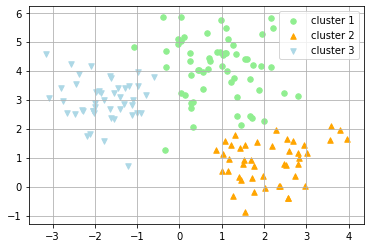

In [3]:
#Sklearnの階層型(凝集型)クラスタリングのお手本はこんな感じ
#データをマージするときの基準の関数(linkage)として，'ward'，'complete'，'average'，'single'がある
#'ward' -> 分散を最小化するようにマージ
#'complete' -> クラスタ間の距離の最大値を最小化するようにマージ
#'average' -> 距離の平均を最小化するようにマージ
#'single' -> 距離の最小値を最小化するようにマージ
#wardが感度がよくていいけど計算量が多くなる，データ数とかに応じて適切なのを選ぶといい
model_agg = cluster.AgglomerativeClustering(n_clusters=3, linkage='ward', compute_full_tree=False)
y_ag = model_agg.fit_predict(X)

plt.scatter(X[y_ag == 0, 0], X[y_ag == 0, 1], s=30, c='lightgreen', marker='o', label='cluster 1')
plt.scatter(X[y_ag == 1, 0], X[y_ag == 1, 1], s=30, c='orange', marker='^', label='cluster 2')
plt.scatter(X[y_ag == 2, 0], X[y_ag == 2, 1], s=30, c='lightblue', marker='v', label='cluster 3')
plt.legend()
plt.grid()
plt.show()

[[0 1]
 [3 5]
 [2 6]
 [4 7]
 [8 9]]


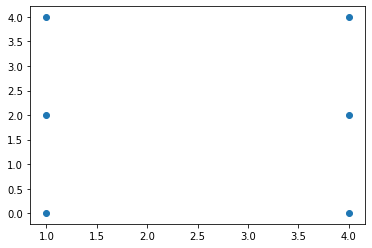

In [4]:
#以下実際の実装
#構造体内部でどのようにデータがマージされたかを木構造で保存する
#scikitlearnのやつでは，「0~サンプル数-1までのデータは葉に相当し，
#childrenの配列でのi番目のノードは子にchildren[i-n_samples]を持つ」とある．
#これはつまりどういうことかというと，0-indexedでノード番号を振っていく．
#元のデータには0~n_samples-1を順に振る．
#そしてマージしていき，マージしたあとのノード(葉ノード以外のノード)にも順に番号を振っていく．
#そして，そのノードの子をペアとして配列のノード番号に対応するところに記録しておくということである．
#例を考えるとわかりやすい．
#以下のコードを実行した
#データセットは非常に簡単な値の6つの点である
data = np.array([[1, 2], [1, 4], [1, 0],[4, 2], [4, 4], [4, 0]])
plt.scatter(data[:,0],data[:,1])
model_agg = cluster.AgglomerativeClustering(n_clusters=3, linkage='ward')
model_agg.fit(data)
print(model_agg.children_)

In [5]:
#各ノードは以下のようなクラスタに相当する
#0->[[1, 2]], 1->[[1, 4]], 2->[[1, 0]],3->[[4, 2]], 4->[[4, 4]], 5->[[4, 0]]
#ここまではchildrenの配列に記録されず，ここからがchildrenの配列に記録されている
#ノード6->ノード0と1のマージしたもの=[[1,2],[1,4]]
#ノード7->3 5をマージしたもの
#...
#これでどのように木構造を保存しているかわかった．

In [7]:
#実装

class AggloOriginal(BaseEstimator, ClusterMixin):
    "階層型クラスタリング"
    def __init__(self, n_clusters=2, linkage="average"):
        self.n_clusters = n_clusters
        self.linkage = linkage
    
    def distance(self, p, q):
        "点pとqの間のユークリッド距離を計算して返す．"
        assert(len(p)==len(q))
        ret = 0
        for i,j in zip(p, q):
            ret += (i-j)**2
        return math.sqrt(ret)

    def distance_pow2(self, p, q):
        "点pとqの間のユークリッド距離の2乗を計算して返す．"
        assert(len(p)==len(q))
        ret = 0
        for i,j in zip(p, q):
            ret += (i-j)**2
        return ret
  
    def G(self, idxs, X):
        n=len(idxs)
        dim=len(X[0])
        ret=np.zeros(dim)
        for j in range(dim):
            tmp=0
            for i in idxs:
                tmp+=X[i][j]
            ret[j]=(tmp/n)
        return ret
  
    def linkage_average(self, s1, s2, X):
        "s1とs2の点の距離を全部図って平均を返す"
        ret = 0
        for p1 in s1:
            for p2 in s2:
                ret += self.distance(X[p1], X[p2])
        return ret / (len(s1)*len(s2))

    def linkage_single(self, s1, s2, X):
        "s1とs2のうちもっとも近い点の距離を返す"
        ret = float('inf')
        for p1 in s1:
            for p2 in s2:
                tmp = self.distance(X[p1], X[p2])
                if tmp < ret:
                  ret=tmp
        return ret

    def linkage_complete(self, s1, s2, X):
        "s1とs2の中の点のうちもっとも遠い点の距離を返す"
        ret = 0.0
        for p1 in s1:
            for p2 in s2:
                tmp = self.distance(X[p1], X[p2])
                if tmp > ret:
                    ret=tmp
        return ret

    def linkage_ward(self, s1, s2, X):
        """2つのクラスタs1とs2が結合したときのその重心と各点の距離の2乗和
          -s1の重心と各点の距離の2乗和-s2の重心と各点の距離の2乗和"""
        #ここバラバラに計算しないでまとめてやったほうが計算量的にはよさそう
        Gs12 = self.G(s1+s2, X)
        Gs1  = self.G(s1, X)
        Gs2  = self.G(s2, X)
        #ret = A - B -C
        A=0
        B=0
        C=0
        for p1 in s1:
            A+=self.distance_pow2(X[p1], Gs12)
            B+=self.distance_pow2(X[p1], Gs1)
        for p2 in s2:
            A+=self.distance_pow2(X[p2], Gs12)
            C+=self.distance_pow2(X[p2], Gs2)
        return A-B-C


    def fit(self, X, y=None):
        "fit,X:data,y:label(not needed)"
        # 葉の数はデータ数に相当
        self.n_leaves_, dim = X.shape
        self.labels_ = np.zeros(self.n_leaves_,dtype=int)
        self.children_ = []   #ここにためていって最後にまとめてndarrayに変換する
        nodeIdx = list(range(self.n_leaves_))   #マージ待ちのノードたち，このサイズが1になったら終わり
        nodeCnt = self.n_leaves_    #ノードの数，ノードをナンバリングする際などに使う
        nodes = [[i] for i in range(self.n_leaves_)] #ノードに含まれるデータを格納する

        while len(nodes) > 1:
            # マージするノードA,Bを決める
            # mergeNodeA,Bはnodesの配列のindexを持たせることに注意
            mergeNodeA=-1
            mergeNodeB=-1
            dis_mini=float('inf')

            for i in range(len(nodes)):
                for j in range(i+1, len(nodes)):
                    dis_tmp=0
                    #2点間の距離をlinkageによって別々な関数を使って帰す
                    if self.linkage == "average":
                        dis_tmp=self.linkage_average(nodes[i], nodes[j], X)
                    #print("{0}と{1}の距離は{2}やで".format(i,j,dis_tmp))
                    elif self.linkage == "single":
                        dis_tmp=self.linkage_single(nodes[i], nodes[j], X)
                    elif self.linkage == "complete":
                        dis_tmp=self.linkage_complete(nodes[i], nodes[j], X)
                    elif self.linkage == "ward":
                        dis_tmp=self.linkage_ward(nodes[i], nodes[j], X)
                    else:
                        print("そんな引数許してないわよ")
                        assert(False)

                    # 2ノードの距離が最小になるものをAとBに記録する
                    if dis_tmp < dis_mini:
                        dis_mini=dis_tmp
                        mergeNodeA=i
                        mergeNodeB=j

            #マージ処理
            nodeCnt+=1
            addingNode = nodes[mergeNodeA]+nodes[mergeNodeB]
            #配列からpopするときに後ろから消さないとズレるので適切にswapしてる
            if mergeNodeA < mergeNodeB:
                mergeNodeA,mergeNodeB = mergeNodeB, mergeNodeA

            nodeIdx.pop(mergeNodeA)
            nodeIdx.pop(mergeNodeB)
            nodeIdx.append(nodeCnt)

            nodes.pop(mergeNodeA)
            nodes.pop(mergeNodeB)
            nodes.append(addingNode)

            li=[]
            li.append(mergeNodeB)
            li.append(mergeNodeA)
            self.children_.append(li)

            # ノードの数が分類したい個数になったらラベル貼りする
            if len(nodes) == self.n_clusters:
                for i,nodeData in enumerate(nodes):
                    for dataIdx in nodeData:
                        self.labels_[dataIdx]=i

        #ndarrayに変換
        self.children_ = np.array(self.children_)
        return self
  


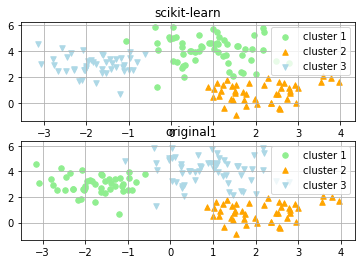

In [14]:
#比較 教師無しなのでクラスタ名は当然異なることがある
# ward

model_agg = cluster.AgglomerativeClustering(n_clusters=3, linkage='ward', compute_full_tree=False)
y_agg = model_agg.fit_predict(X)

model_ori = AggloOriginal(n_clusters=3, linkage='ward')
y_ori = model_ori.fit_predict(X)

plt.subplot(2,1,1)
plt.title("scikit-learn")
plt.scatter(X[y_agg == 0, 0], X[y_agg == 0, 1], s=30, c='lightgreen', marker='o', label='cluster 1')
plt.scatter(X[y_agg == 1, 0], X[y_agg == 1, 1], s=30, c='orange', marker='^', label='cluster 2')
plt.scatter(X[y_agg == 2, 0], X[y_agg == 2, 1], s=30, c='lightblue', marker='v', label='cluster 3')
plt.legend()
plt.grid()


plt.subplot(2,1,2)
plt.title("original")
plt.scatter(X[y_ori == 0, 0], X[y_ori == 0, 1], s=30, c='lightgreen', marker='o', label='cluster 1')
plt.scatter(X[y_ori == 1, 0], X[y_ori == 1, 1], s=30, c='orange', marker='^', label='cluster 2')
plt.scatter(X[y_ori == 2, 0], X[y_ori == 2, 1], s=30, c='lightblue', marker='v', label='cluster 3')
plt.legend()
plt.grid()

plt.show()


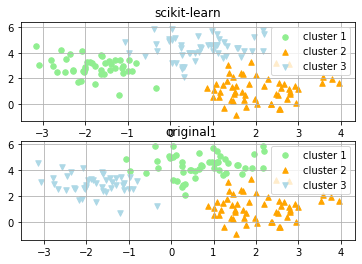

In [15]:
#比較 教師無しなのでクラスタ名は当然異なることがある
# average

model_agg = cluster.AgglomerativeClustering(n_clusters=3, linkage='average', compute_full_tree=False)
y_agg = model_agg.fit_predict(X)

model_ori = AggloOriginal(n_clusters=3, linkage='average')
y_ori = model_ori.fit_predict(X)

plt.subplot(2,1,1)
plt.title("scikit-learn")
plt.scatter(X[y_agg == 0, 0], X[y_agg == 0, 1], s=30, c='lightgreen', marker='o', label='cluster 1')
plt.scatter(X[y_agg == 1, 0], X[y_agg == 1, 1], s=30, c='orange', marker='^', label='cluster 2')
plt.scatter(X[y_agg == 2, 0], X[y_agg == 2, 1], s=30, c='lightblue', marker='v', label='cluster 3')
plt.legend()
plt.grid()


plt.subplot(2,1,2)
plt.title("original")
plt.scatter(X[y_ori == 0, 0], X[y_ori == 0, 1], s=30, c='lightgreen', marker='o', label='cluster 1')
plt.scatter(X[y_ori == 1, 0], X[y_ori == 1, 1], s=30, c='orange', marker='^', label='cluster 2')
plt.scatter(X[y_ori == 2, 0], X[y_ori == 2, 1], s=30, c='lightblue', marker='v', label='cluster 3')
plt.legend()
plt.grid()

plt.show()


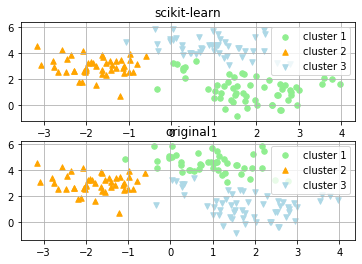

In [16]:
#比較 教師無しなのでクラスタ名は当然異なることがある
# complete

model_agg = cluster.AgglomerativeClustering(n_clusters=3, linkage='complete', compute_full_tree=False)
y_agg = model_agg.fit_predict(X)

model_ori = AggloOriginal(n_clusters=3, linkage='complete')
y_ori = model_ori.fit_predict(X)

plt.subplot(2,1,1)
plt.title("scikit-learn")
plt.scatter(X[y_agg == 0, 0], X[y_agg == 0, 1], s=30, c='lightgreen', marker='o', label='cluster 1')
plt.scatter(X[y_agg == 1, 0], X[y_agg == 1, 1], s=30, c='orange', marker='^', label='cluster 2')
plt.scatter(X[y_agg == 2, 0], X[y_agg == 2, 1], s=30, c='lightblue', marker='v', label='cluster 3')
plt.legend()
plt.grid()


plt.subplot(2,1,2)
plt.title("original")
plt.scatter(X[y_ori == 0, 0], X[y_ori == 0, 1], s=30, c='lightgreen', marker='o', label='cluster 1')
plt.scatter(X[y_ori == 1, 0], X[y_ori == 1, 1], s=30, c='orange', marker='^', label='cluster 2')
plt.scatter(X[y_ori == 2, 0], X[y_ori == 2, 1], s=30, c='lightblue', marker='v', label='cluster 3')
plt.legend()
plt.grid()

plt.show()


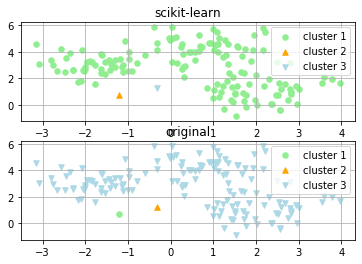

In [17]:
#比較 教師無しなのでクラスタ名は当然異なることがある
# single

model_agg = cluster.AgglomerativeClustering(n_clusters=3, linkage='single', compute_full_tree=False)
y_agg = model_agg.fit_predict(X)

model_ori = AggloOriginal(n_clusters=3, linkage='single')
y_ori = model_ori.fit_predict(X)

plt.subplot(2,1,1)
plt.title("scikit-learn")
plt.scatter(X[y_agg == 0, 0], X[y_agg == 0, 1], s=30, c='lightgreen', marker='o', label='cluster 1')
plt.scatter(X[y_agg == 1, 0], X[y_agg == 1, 1], s=30, c='orange', marker='^', label='cluster 2')
plt.scatter(X[y_agg == 2, 0], X[y_agg == 2, 1], s=30, c='lightblue', marker='v', label='cluster 3')
plt.legend()
plt.grid()


plt.subplot(2,1,2)
plt.title("original")
plt.scatter(X[y_ori == 0, 0], X[y_ori == 0, 1], s=30, c='lightgreen', marker='o', label='cluster 1')
plt.scatter(X[y_ori == 1, 0], X[y_ori == 1, 1], s=30, c='orange', marker='^', label='cluster 2')
plt.scatter(X[y_ori == 2, 0], X[y_ori == 2, 1], s=30, c='lightblue', marker='v', label='cluster 3')
plt.legend()
plt.grid()

plt.show()


In [ ]:
#お手本と同じ分類ができているので成功と言っていいと思う．
#ただ，データ量を増やすとwardに関しては自分のがsklearnのに比べて大分遅かった
#さすがsklearn，うまくやってるんだなぁという感想
#そしてやはりsingleは特性上データが密だと上のようにいい分類ができなさそう．